torch.Size([3, 485, 341])
torch.Size([300, 300, 3])


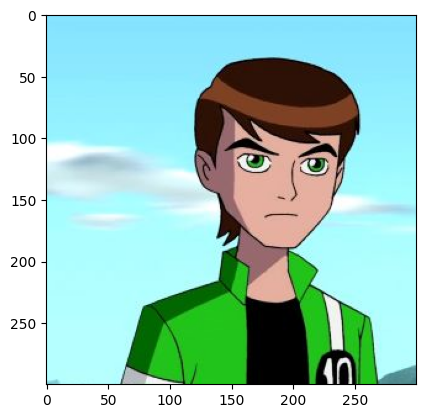

In [59]:
import torch
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np

img = torchvision.io.read_image('ben_10_copy.jpg')
img = img.clone()
print(img.shape)
img = torchvision.transforms.functional.crop(img, 0, 0, 300, 300)
img = img.permute(1,2,0)
img = img/255.0  # Normalize 
print(img.shape)
plt.imshow(img)

In [60]:
def compute_rmse(tensor1, tensor2):
    assert tensor1.shape == tensor2.shape, "Tensors must have the same shape"
    mse = torch.mean((tensor1 - tensor2) ** 2)
    rmse = torch.sqrt(mse)
    return rmse.item()

def compute_psnr(tensor1, tensor2, max_pixel_value=1.0):
    mse = torch.mean((tensor1 - tensor2) ** 2)
    psnr = 10 * torch.log10(max_pixel_value ** 2 / mse)
    return psnr.item()

In [61]:
def matrix_factorization(A, k, device=torch.device("cpu"), epsilon=0.001):
    """Factorize the matrix A into W and H"""
    A = A.to(device)
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device)
    optimizer = optim.Adam([W, H], lr=0.01)
    mask = ~torch.isnan(A)
    epoch = 0
    prev_loss = float('inf')
    while True:
        diff_matrix = torch.mm(W, H) - A
        diff_vector = diff_matrix[mask]
        loss = torch.norm(diff_vector)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch += 1
        if prev_loss - loss < epsilon:
            break
        prev_loss = loss

    return W, H, loss

def factorize_3d(A, k, device=torch.device("cpu"), epsilon = 0.001):
	A = A.to(device)
	if A.shape[2] == 3:
		# A1,A2,A3 = A[:,:,0],A[:,:,1],A[:,:,2]
		A_3d = A.permute(2,0,1)
	else:
		A_3d = A
	W_3d = []
	H_3d = []
	loss_3d = []

	for a in A_3d:
		W,H,loss = matrix_factorization(a,k,device,epsilon)
		W_3d.append(W)
		H_3d.append(H)
		loss_3d.append(loss)

	return W_3d,H_3d,loss_3d

def reconstruct_3d_img(masked_image,factors,device=torch.device("cpu")):
	W_3d,H_3d,_ = factorize_3d(masked_image,factors,device)
	A = []
	for i in range(3):
		a = torch.mm(W_3d[i], H_3d[i]).cpu().detach()
		A.append(a)
	A = torch.stack(A)
	A = A.permute(1,2,0)
	A = torch.clamp(A,min=0,max=1)
	return A.cpu().detach()

In [62]:
# Parameters
patch_size = 50
stride = patch_size  # Non-overlapping patches
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def extract_patches(image, patch_size, stride):
    patches = []
    for i in range(0, image.shape[0] - patch_size + 1, stride):
        for j in range(0, image.shape[1] - patch_size + 1, stride):
            patch = image[i:i+patch_size, j:j+patch_size]
            patches.append(patch)
    return patches

patches = extract_patches(img, patch_size, stride)

In [63]:
def combine_patches(patches, img_shape, patch_size, stride):
    reconstructed_img = torch.zeros(img_shape)
    count = torch.zeros(img_shape)
    
    idx = 0
    for i in range(0, img_shape[0] - patch_size + 1, stride):
        for j in range(0, img_shape[1] - patch_size + 1, stride):
            patch = patches[idx]
            reconstructed_img[i:i+patch_size, j:j+patch_size] += patch
            count[i:i+patch_size, j:j+patch_size] += 1
            idx += 1
    
    return reconstructed_img / count



In [64]:
def mask_image(img, prop):
    img_copy = img.clone()
    img_copy = img_copy.to(torch.float)
    mask = torch.rand(img.shape) < prop
    img_copy[mask] = float('nan')
    return img_copy, mask

In [65]:
def plot_image_completion(original_img, patches, patch_size, stride, factors):
    reconstructed_patches = []
    # masked_patches = []
    for patch in patches:
        # masked_patch, _ = mask_image(patch, 0)
        # masked_patches.append(masked_patch)
        # W, H, _ = matrix_factorization(masked_patch, factors, device=device)
        reconstructed_patch = reconstruct_3d_img(patch,factors,device=device)
        reconstructed_patches.append(reconstructed_patch)

    # masked_image = combine_patches(patches, original_img.shape, patch_size, stride)
    reconstructed_img = combine_patches(reconstructed_patches, original_img.shape, patch_size, stride)
    original_img = original_img.cpu().detach()

 
    return reconstructed_img,original_img,reconstructed_patches

In [92]:
def plot_image_completion_for_1_path(original_img, patches, patch_size, stride, factors):
    reconstructed_patches = []
    # masked_patches = []
    cnt = 0
    for patch in patches:
        # masked_patch, _ = mask_image(patch, 0)
        # masked_patches.append(masked_patch)
        # W, H, _ = matrix_factorization(masked_patch, factors, device=device)
        reconstructed_patch = patch
        if cnt == 8 or cnt == 34 or cnt == 15 or cnt == 16:
            reconstructed_patch = reconstruct_3d_img(patch,factors,device=device)
        reconstructed_patches.append(reconstructed_patch)
        cnt = cnt + 1

    # masked_image = combine_patches(patches, original_img.shape, patch_size, stride)
    reconstructed_img = combine_patches(reconstructed_patches, original_img.shape, patch_size, stride)
    original_img = original_img.cpu().detach()

 
    return reconstructed_img,original_img,reconstructed_patches

0.2037336826324463
13.818742752075195


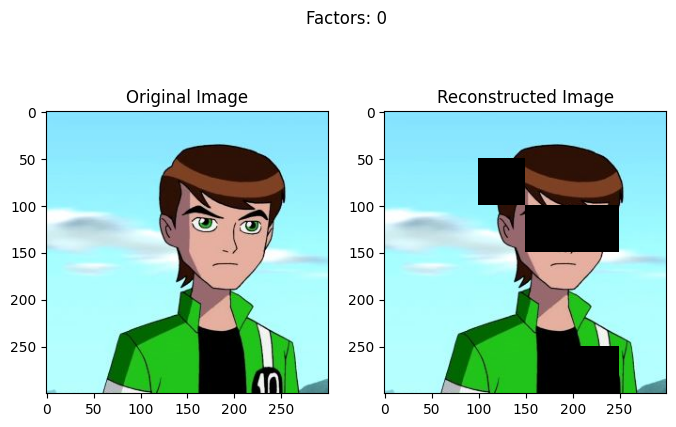

0.05453143268823624
25.26706314086914


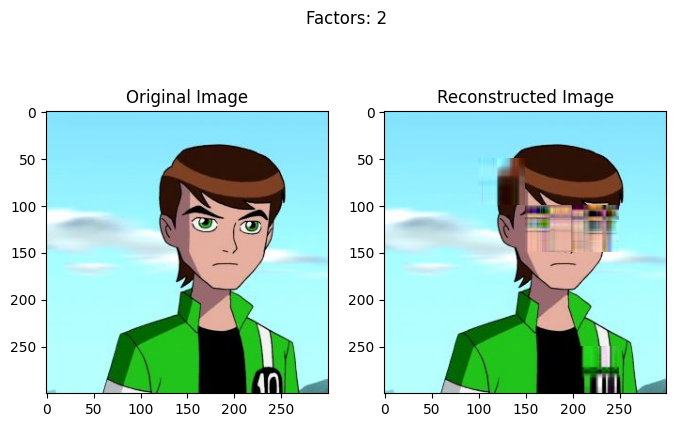

0.03631554916501045
28.798145294189453


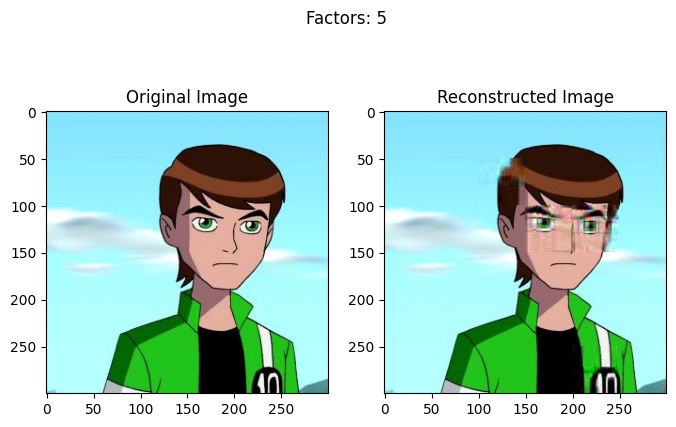

0.023204240947961807
32.68865203857422


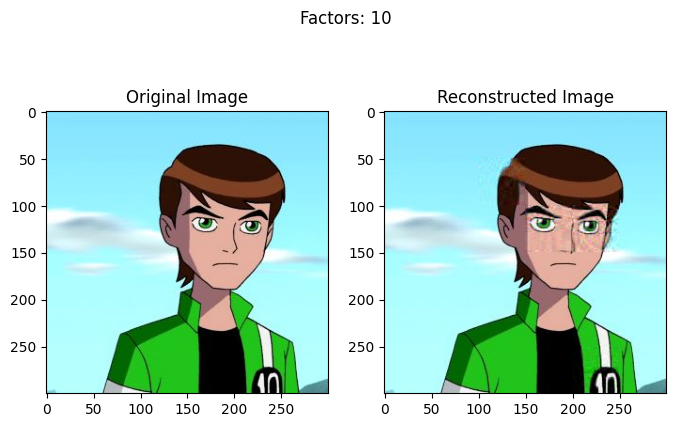

0.014829551801085472
36.57743835449219


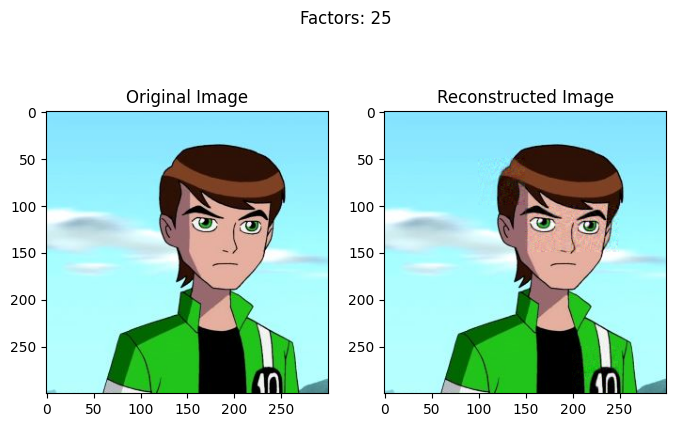

0.01107209362089634
39.11540603637695


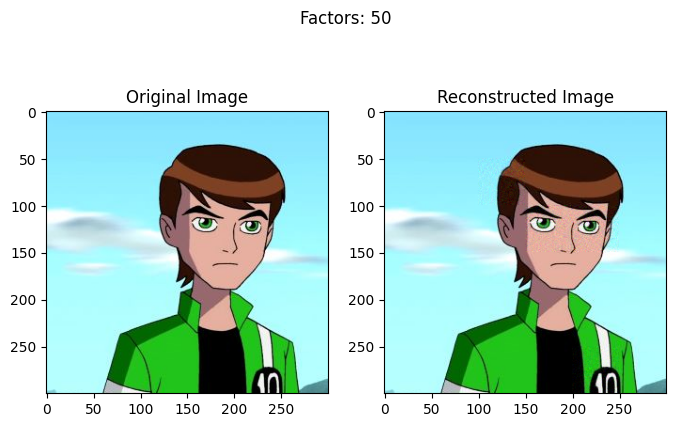

In [94]:
for r in [0,2, 5, 10, 25, 50]:
    reconstructed_img,original_img,_ = plot_image_completion_for_1_path(img, patches, patch_size, stride, r)
    print(compute_rmse(original_img,reconstructed_img))
    print(compute_psnr(original_img,reconstructed_img))
    plt.figure(figsize=(8, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_img, cmap='gray')
    plt.title("Reconstructed Image")

    plt.suptitle(f'Factors: {r}')
    plt.show()

[8, 34, 15, 16]


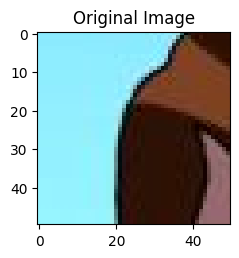

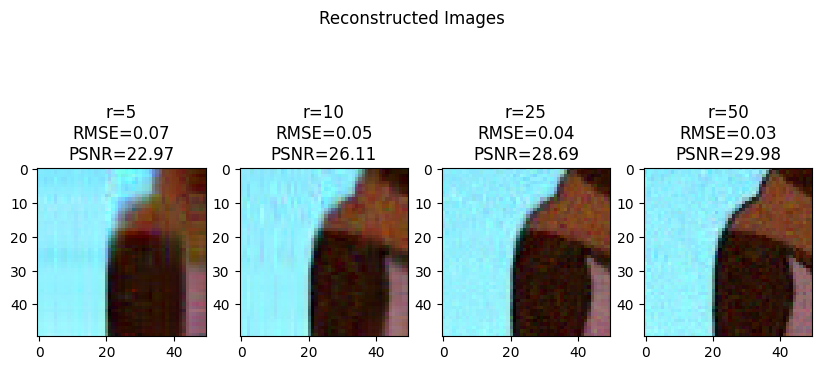

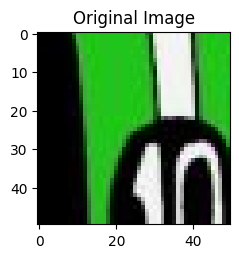

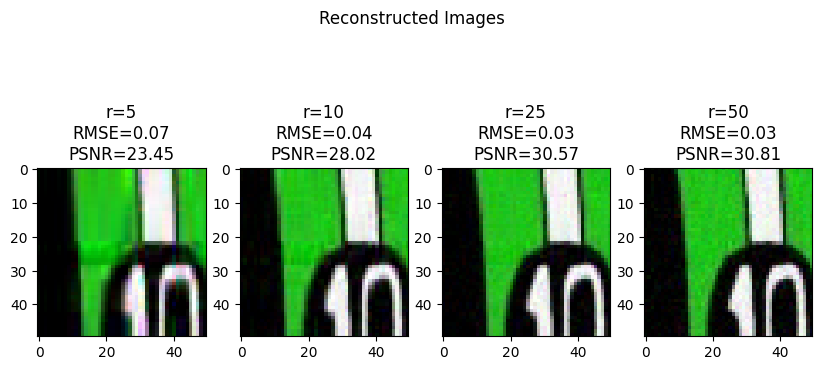

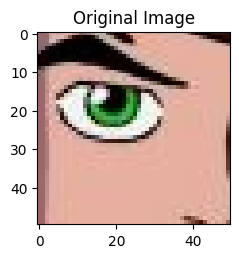

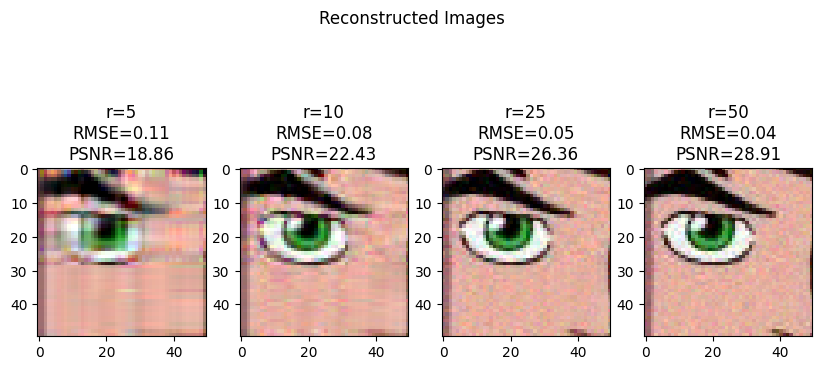

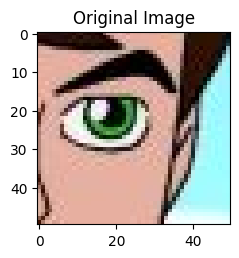

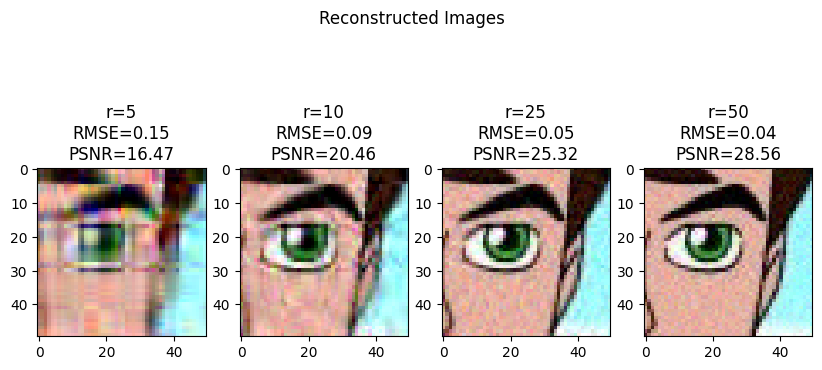

In [93]:
list_l = [8,34,15,16]

print(list_l)
for cnt in list_l:
    plt.figure(figsize=(2.5, 2.5))
    plt.subplot(1, 1, 1)
    plt.imshow(patches[cnt], cmap='gray')
    plt.title("Original Image")
    plt.show()
    plt.figure(figsize=(10, 5))
    index = 0
    for r in [5, 10, 25, 50]:
        _,_,reconstructed_patches = plot_image_completion(img, patches, patch_size, stride, r)    
        index = index + 1
        plt.subplot(1, 4, index)
        plt.imshow(reconstructed_patches[cnt].cpu().detach().numpy(), cmap='gray') 
        rmse = compute_rmse(reconstructed_patches[cnt],patches[cnt])
        psnr = compute_psnr(reconstructed_patches[cnt],patches[cnt])
        plt.title(f'r={r}\nRMSE={rmse:.2f}\nPSNR={psnr:.2f}')
    
    plt.suptitle(f'Reconstructed Images')
    plt.show()



